In [1]:
import numpy as np
import scipy.io as sio
from os import listdir
from scipy import stats
import sys
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow as tf

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

4 Physical GPUs, 1 Logical GPU


In [3]:
s25 = np.load('s25.npy')
h25 = np.load('h25.npy')

In [4]:
s25_labels = np.array([0 for _ in range(0,len(s25))])
h25_labels = np.array([1 for _ in range(0,len(h25))])

In [5]:
X = np.append(s25,h25,axis=0)

In [6]:
X = stats.zscore(X, axis=1)

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [7]:
y = np.append(s25_labels,h25_labels,axis=0)

In [8]:
def define_model():
    model = Sequential()

    model.add(layers.Conv1D(5, 10, strides = 1,  input_shape = (6250,19)))
    model.add(LeakyReLU())
    model.add(layers.MaxPooling1D(pool_size = 2, strides = 2))

    model.add(layers.Conv1D(10, 10, strides = 1))
    model.add(LeakyReLU())
    model.add(layers.MaxPooling1D(pool_size = 2, strides = 2))

    model.add(layers.Conv1D(10, 10, strides = 1))
    model.add(LeakyReLU())
    model.add(layers.MaxPooling1D(pool_size = 2, strides = 2))

    model.add(layers.Conv1D(15, 5, strides = 1))
    model.add(LeakyReLU())
    model.add(layers.MaxPooling1D(pool_size = 2, strides = 2))

    model.add(layers.Flatten())

    model.add(layers.Dense(20))
    model.add(LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(10))
    model.add(LeakyReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(2, activation = 'softmax'))
    print(model.summary())
    return model

In [9]:
def summerize_diagnostics_Acc(history):
    plt.figure(0)
    plt.title("train / validation accuracy")
    plt.plot(history.history["accuracy"] , c = 'red' , label = 'train_acc')
    plt.plot(history.history["val_accuracy"] , c = 'blue' , label = 'test_acc')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    #plt.savefig('drive/My Drive/SchizophreniaAccPic/'+str(fold_no)+'_plot.png')
    plt.show()
    plt.close()


def summerize_diagnostics_Loss(history):
    plt.figure(1)
    plt.title("train / validation loss")
    plt.plot(history.history["loss"] , c = 'red' , label = 'train_loss')
    plt.plot(history.history["val_loss"] ,c = 'blue' , label = 'test_loss')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend()
    #plt.savefig('drive/My Drive/SchizophreniaLossPic/'+str(fold_no)+'_plot.png')
    plt.show()
    plt.close()

In [10]:
def run_test_harness(train_features, train_labels, test_features, test_labels, validation_features, validation_labels):
    # define model
    model = define_model()
    
    # compile model
    model.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(lr = 0.0001), metrics = ['accuracy'])

    # fit model
    history = model.fit(train_features, train_labels, validation_data = (validation_features, validation_labels), epochs = 70, batch_size = 15, verbose = 0)
    
    # evaluate model
    _,acc = model.evaluate(test_features, test_labels, verbose = 0)
    print('Test Acc > %3f '  %(acc*100))

    # clasification metrics
    pred = model.predict(test_features, batch_size=15, verbose=0)
    predicted = np.argmax(pred, axis=1)
    #print("predicted is = ", predicted )
    report = classification_report(np.argmax(test_labels, axis=1), predicted)
    print(report)

    # get the confusion matrix
    cf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), predicted)
    print("cf_matrix = ", cf_matrix)

    # plot the confusion matrix
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

    # learning curves
    summerize_diagnostics_Acc(history)
    summerize_diagnostics_Loss(history)

    return history,cf_matrix

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3120, 5)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1555, 10)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1546, 10)          1

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

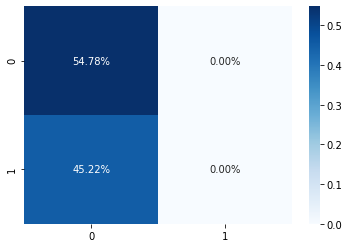

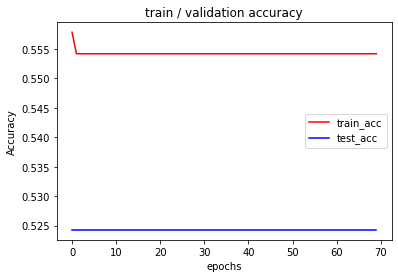

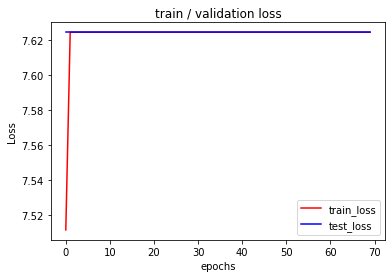

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 3120, 5)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 1555, 10)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        63
           1       0.00      0.00      0.00        52

    accuracy                           0.55       115
   macro avg       0.27      0.50      0.35       115
weighted avg       0.30      0.55      0.39       115

cf_matrix =  [[63  0]
 [52  0]]


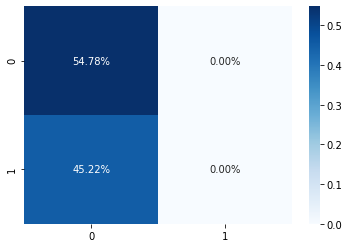

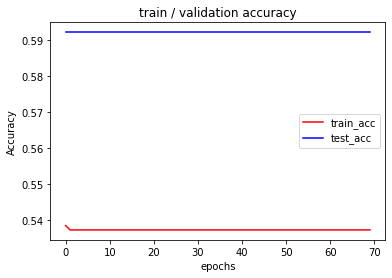

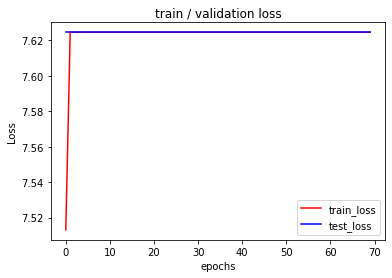

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 3120, 5)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 1555, 10)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

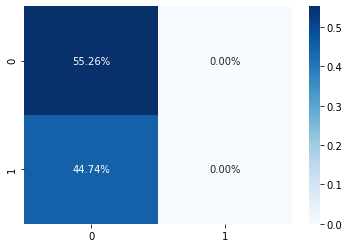

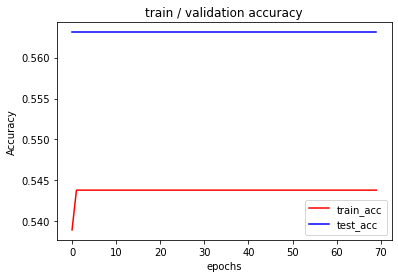

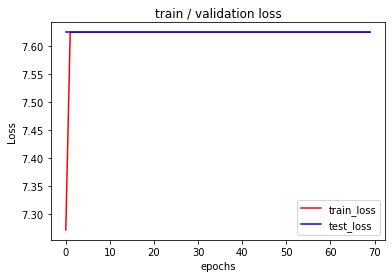

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 3120, 5)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 1555, 10)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

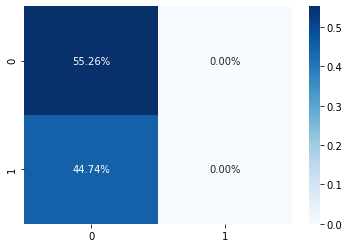

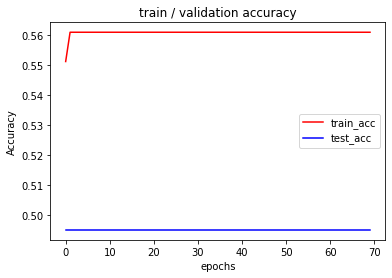

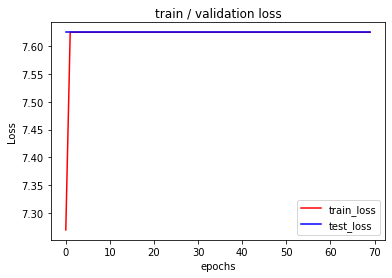

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 3120, 5)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 1555, 10)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        63
           1       0.00      0.00      0.00        51

    accuracy                           0.55       114
   macro avg       0.28      0.50      0.36       114
weighted avg       0.31      0.55      0.39       114

cf_matrix =  [[63  0]
 [51  0]]


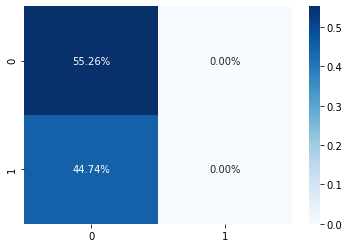

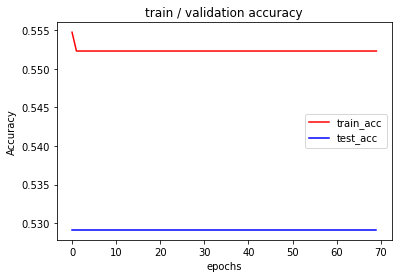

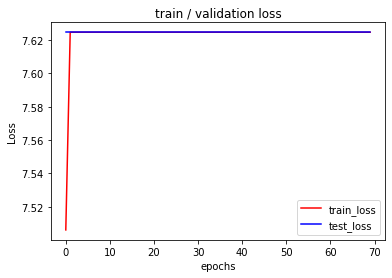

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 3120, 5)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 1555, 10)          0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

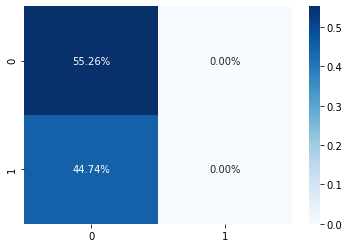

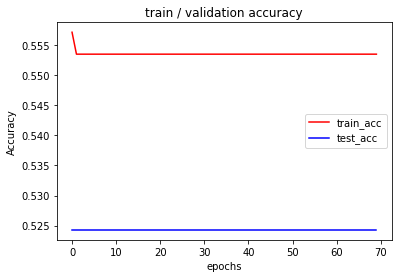

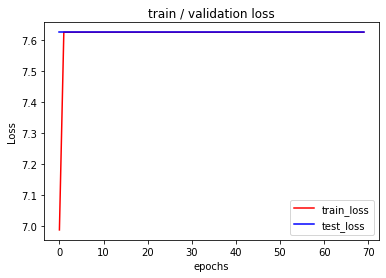

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 3120, 5)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 1555, 10)          0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

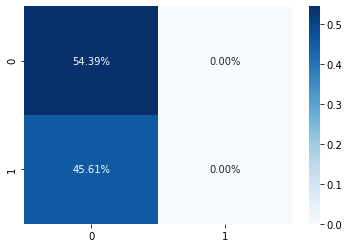

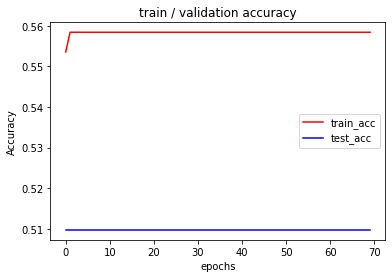

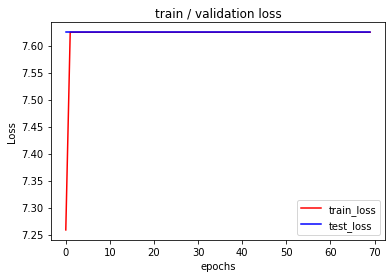

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_42 (LeakyReLU)   (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 3120, 5)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 1555, 10)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

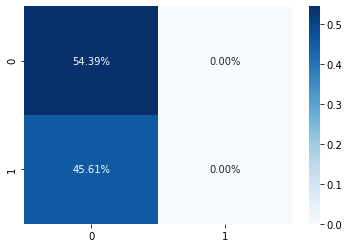

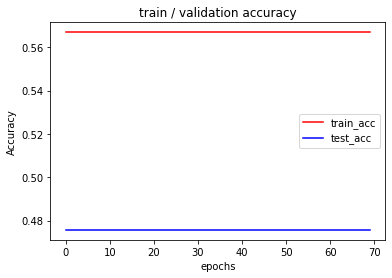

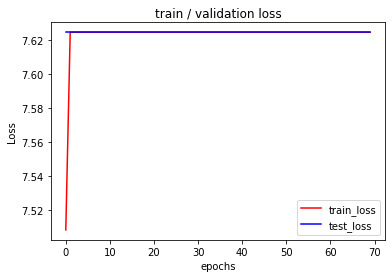

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_48 (LeakyReLU)   (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 3120, 5)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 1555, 10)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

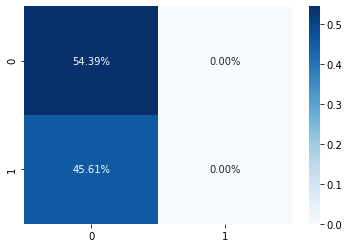

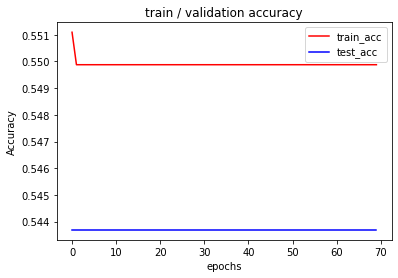

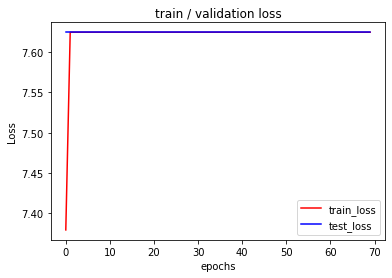

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 6241, 5)           955       
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 6241, 5)           0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 3120, 5)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 3111, 10)          510       
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 3111, 10)          0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1555, 10)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1546, 10)         

/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonathan/.virtualenvs/tensorflow2/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        62
           1       0.00      0.00      0.00        52

    accuracy                           0.54       114
   macro avg       0.27      0.50      0.35       114
weighted avg       0.30      0.54      0.38       114

cf_matrix =  [[62  0]
 [52  0]]


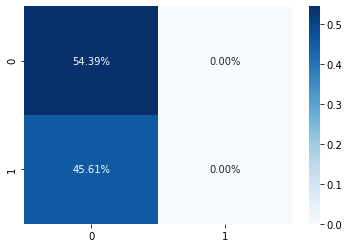

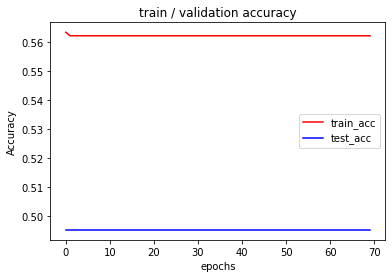

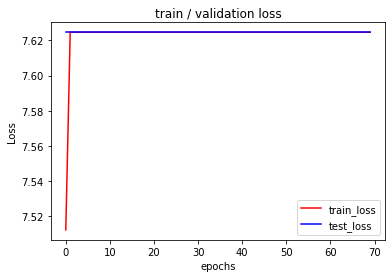

histories =  [<tensorflow.python.keras.callbacks.History object at 0x7f7b0038f748>, <tensorflow.python.keras.callbacks.History object at 0x7f7bb0688f98>, <tensorflow.python.keras.callbacks.History object at 0x7f7bb0737ba8>, <tensorflow.python.keras.callbacks.History object at 0x7f7b5a94a588>, <tensorflow.python.keras.callbacks.History object at 0x7f7b59d35ba8>, <tensorflow.python.keras.callbacks.History object at 0x7f7bb04bff98>, <tensorflow.python.keras.callbacks.History object at 0x7f7ab81bdc18>, <tensorflow.python.keras.callbacks.History object at 0x7f7aa84ea278>, <tensorflow.python.keras.callbacks.History object at 0x7f7aa85ea6a0>, <tensorflow.python.keras.callbacks.History object at 0x7f7b000cb470>]
confusion =  [array([[63,  0],
       [52,  0]]), array([[63,  0],
       [52,  0]]), array([[63,  0],
       [51,  0]]), array([[63,  0],
       [51,  0]]), array([[63,  0],
       [51,  0]]), array([[63,  0],
       [51,  0]]), array([[62,  0],
       [52,  0]]), array([[62,  0],
   

In [13]:

histories = []
confusion = []

fold_no = 1
kfold=StratifiedKFold(n_splits = 10, shuffle = True)
for train, test in kfold.split(X, y):
    train_features = X[train]
    train_labels = y[train]
    test_features = X[test]
    test_labels = y[test]

    # 20% of train data is used for validation
    train_features, validation_features , train_labels, validation_labels = train_test_split(train_features, train_labels, test_size = 0.2)

    # binary labels,encoding labels
    import pandas as pd
    train_labels = np.asarray(pd.get_dummies(train_labels), dtype = np.int8)
    test_labels = np.asarray(pd.get_dummies(test_labels), dtype = np.int8)
    validation_labels = np.asarray(pd.get_dummies(validation_labels), dtype = np.int8)

    # run the test harness
    h,c = run_test_harness(train_features, train_labels, test_features, test_labels, validation_features, validation_labels)
    histories.append(h)
    confusion.append(c)
    fold_no += 1


print("histories = ", histories)
print("confusion = ", confusion)